In [1]:
from zipfile import ZipFile
file_name="TSR.zip"
with ZipFile(file_name,'r') as zip:
   zip.extractall()
   print('done')

done


In [ ]:
import os
Root = "/content/TSR"
os.chdir(Root)

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

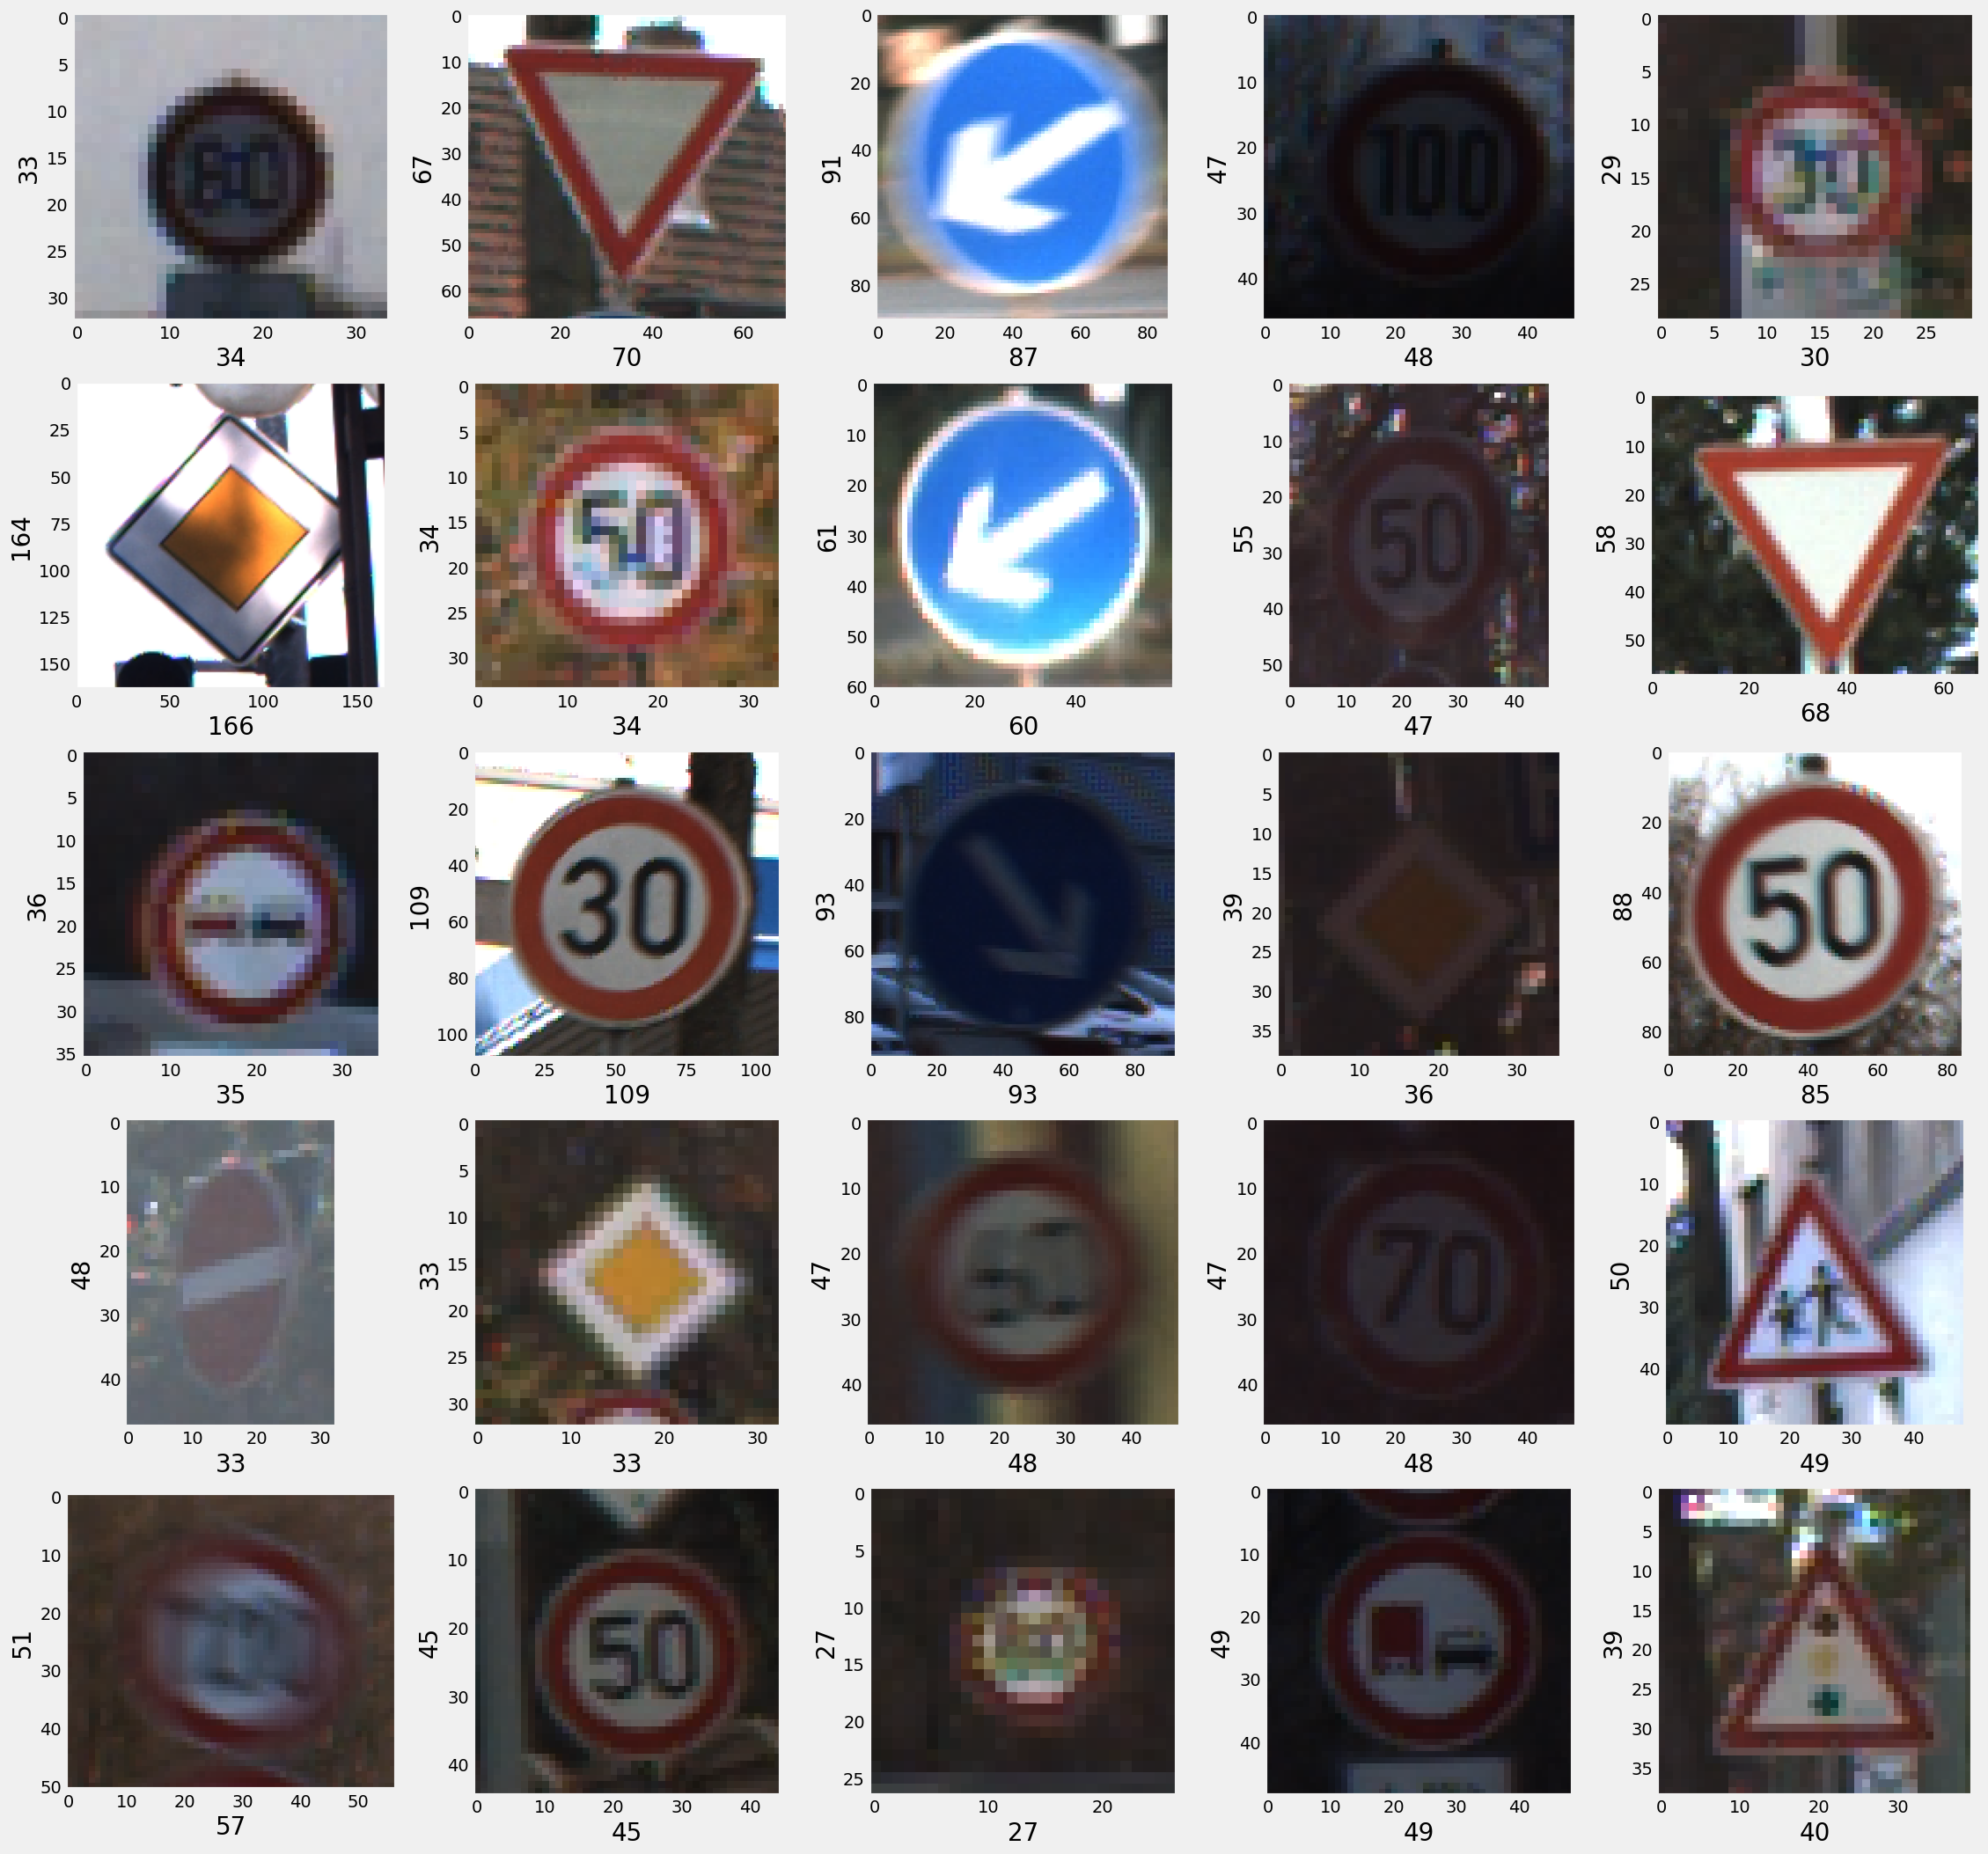

In [4]:
import random
data_dir = '/content/TSR'
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)# Use plt.grid(False) to disable the grid
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [5]:
image_data = []
image_labels = []

IMG_HEIGHT = 50
IMG_WIDTH  = 50

NUM_CATEGORIES = len(os.listdir(data_dir+"/Train/"))
print("Total number of classes are : "+str(NUM_CATEGORIES))

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        image = cv2.imread(path + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        image_data.append(np.array(resize_image))
        image_labels.append(i)

#list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

Total number of classes are : 43


In [6]:
image_labels.shape

(39209,)

In [7]:
image_data.shape

(39209, 50, 50, 3)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

In [9]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [10]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

lr = 0.001
epochs = 30

opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [22]:
from tensorflow.keras.optimizers import Adam

lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [11]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))


Epoch 1/30
858/858 [==============================] - 355s 411ms/step - loss: 1.0065 - accuracy: 0.7329 - val_loss: 0.0872 - val_accuracy: 0.9763
Epoch 2/30
858/858 [==============================] - 360s 420ms/step - loss: 0.1586 - accuracy: 0.9531 - val_loss: 0.0384 - val_accuracy: 0.9889
Epoch 3/30
858/858 [==============================] - 374s 436ms/step - loss: 0.0841 - accuracy: 0.9751 - val_loss: 0.0486 - val_accuracy: 0.9852
Epoch 4/30
858/858 [==============================] - 376s 438ms/step - loss: 0.0686 - accuracy: 0.9794 - val_loss: 0.0278 - val_accuracy: 0.9917
Epoch 5/30
858/858 [==============================] - 367s 428ms/step - loss: 0.0609 - accuracy: 0.9822 - val_loss: 0.0184 - val_accuracy: 0.9950
Epoch 6/30
858/858 [==============================] - 374s 436ms/step - loss: 0.0508 - accuracy: 0.9845 - val_loss: 0.0091 - val_accuracy: 0.9968
Epoch 7/30
858/858 [==============================] - 376s 439ms/step - loss: 0.0394 - accuracy: 0.9873 - val_loss: 0.0092 -

<ipython-input-12-dcc572878ae4>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


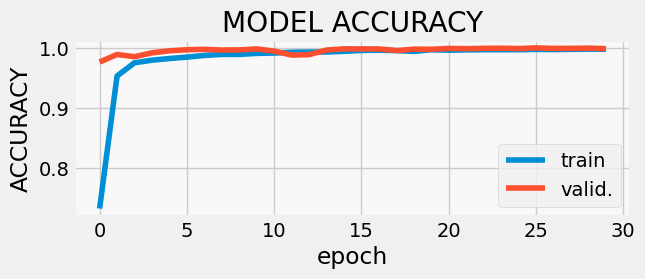

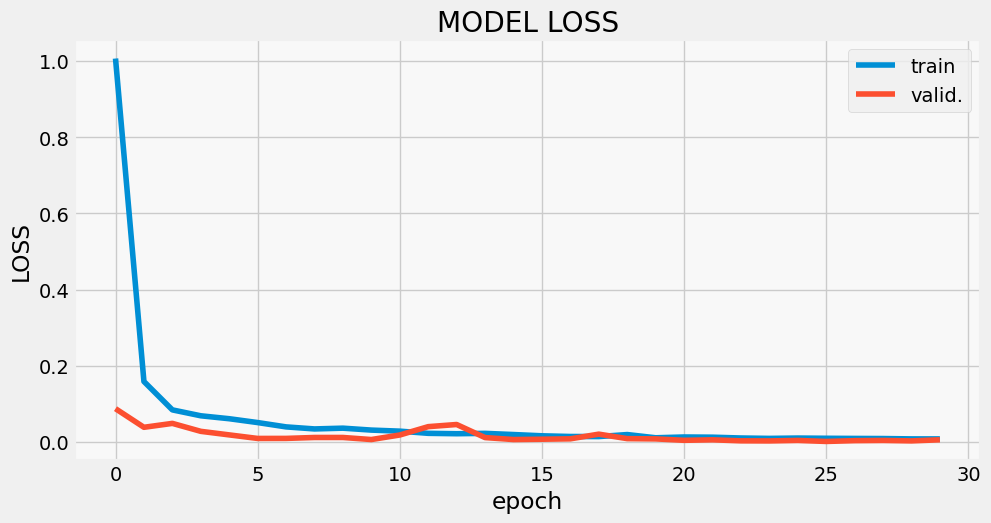

In [12]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'ACCURACY',
    212,
)
    

display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'LOSS',
    211,
)  

In [13]:
score = model.evaluate(X_train,y_train,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

858/858 [==============================] - 75s 88ms/step - loss: 2.5781e-04 - accuracy: 0.9999
Accuracy: 99.99%
Loss:  0.00025781142176128924


In [14]:
score = model.evaluate(X_val, y_val,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

368/368 [==============================] - 32s 88ms/step - loss: 0.0055 - accuracy: 0.9986
Accuracy: 99.86%
Loss:  0.0055456142872571945


In [15]:
!mkdir '/content/model'
model.save('/content/model')

!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/fingerprint.pb (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 88%)
  adding: content/model/keras_metadata.pb (deflated 93%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 71%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 7%)


In [17]:
model.save("model.h5")

In [18]:
model.save_weights("/content/TSR/output")

In [31]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow

reconstructed_model = tf.keras.models.load_model('/content/model')

def GetResultForImage(image_location):
  img = cv2.imread(image_location, cv2.COLOR_BGR2RGB)
  # Must be  (x,x,3)
  #print('Original Dimensions : ',img.shape)
  resized = cv2.resize(img,(50,50),3)
  result = np.expand_dims(resized, axis=0)
  result=reconstructed_model.predict(result)
  print(np.argmax(result))
  cv2_imshow(resized)

1/1 [==============================] - 0s 135ms/step
33


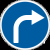

In [34]:
GetResultForImage("/content/TSR/Meta/33.png")
#Expecting 33

1/1 [==============================] - 0s 33ms/step
39


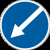

In [35]:
GetResultForImage("/content/TSR/Meta/39.png")
#Expecting 39

1/1 [==============================] - 0s 44ms/step
16


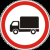

In [36]:
GetResultForImage("/content/TSR/Meta/16.png")
#Expecting 16

In [33]:
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/TSR/Test/00009.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((50, 50))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
result
 

1/1 [==============================] - 0s 233ms/step


5